# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** 37

**Author 1 (sciper):** Michael Biselx    (283812)  
**Author 2 (sciper):** Bastien Darbellay (288406)   
**Author 3 (sciper):** Maria   Guerraoui (274578)  

**Release date:** 07.04.2022
**Due date:** 29.04.2022


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [2]:
import scipy.io

data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

(200, 2) (200, 2) (200, 2)


### 1.1 Bayes method (5 pts)
Using the Bayes method, give the expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data. Note that you do not need to solve the analytical expression. You can simply evaluate the function for each point on the plane to end up with a segmentation map.
For simplicity reasons, round the estimated parameters to the closest integer value.

In [3]:
# visualisation of the data (since it is low-dimensional data this is possible)
import numpy as np
from   scipy.stats import multivariate_normal
import matplotlib.colors
import matplotlib.pyplot as plt
from   matplotlib.patches import Ellipse
%matplotlib inline

def visualize_data(datas, lbls=[], stats=[], ax=[], cmap=[]): 
    while len(lbls)  < len(datas) : lbls.append([])
    while len(stats) < len(datas) : stats.append([])  
    if ax==[]   : fig, ax = plt.subplots(1,1, figsize=(10, 5))
    if cmap==[] : cmap = matplotlib.colors.ListedColormap(['r', 'g', 'b', 'y'])
        
    for data, lbl, stat, c in zip(datas, lbls, stats, range(len(lbls))) : 
        
        # plot scattering of data
        ax.scatter(data[:,0], data[:,1], s=1, color=cmap(c), label=lbl)
        
        # if statistics on the data are available
        if len(stat) : 
            # plot the mean
            ax.scatter(stat[0][0], stat[0][1], color=cmap(c))
            
            # plot the covariance 
            [v, w] = np.linalg.eig(stat[1])
            x = sorted(zip(v,w), reverse=True)
            v = [v for v,w in x]           # eigenvalues give the standard deviation
            w = x[0][1]                    # largest eigenvector gives the rotation of the semimajor axis
            semimaj = np.sqrt(5.991*v[0])  # 95% prdicition semimajor axis
            semimin = np.sqrt(5.991*v[1])  # 95% prdicition semiminor axis
            angle   = np.rad2deg(np.arctan2(w[1], w[0]))
            ellipse = Ellipse(stat[0], width =2*semimaj, height=2*semimin, angle=angle,
                              alpha=.2, facecolor=cmap(c))
            ax.add_artist(ellipse)
            
    ax.set_title("data visualisation")
    ax.legend()

    
def get_stats(data) : # get the statistics for a class of data
    mean = np.mean(data, axis=0)
    cov  = np.cov(data, rowvar=False)
    return mean, cov   
    

def partition_space_Bayes(priors, stats, extent, res=0.1) : 
    X,Y  = np.mgrid[extent[0]:extent[1]:res, extent[2]:extent[3]:res]
    grid = np.dstack((X, Y))
    
    # we assume the distributions are normal (gaussian) 
    # and get the probablity of finding a point of each class in any point of the grid
    grid_probs = [prior * multivariate_normal(stat[0], stat[1]).pdf(grid) for prior, stat in zip(priors, stats)]

    partition = np.argmax(grid_probs, axis=0).astype(int) # get the class with the maximum likelyhood for each gridpoint wins
    
    return partition, grid_probs;
   
    
def get_misclassified(data, label, grid, extent) : # extract the datapoints which are misclassified by a partitioning
    data_idx_x = (grid.shape[0] * (data[:,0] - extent[0]) / (extent[1] - extent[0])).astype(int); # rescale data to grid indices
    data_idx_y = (grid.shape[1] * (data[:,1] - extent[2]) / (extent[3] - extent[2])).astype(int); # rescale data to grid indices
    misclassified = data[(grid[data_idx_x, data_idx_y] != label),:]
    
    return misclassified
    
    
def draw_misclassified(datas, labels, grid, extent, ax=[]) :  # draw the misclassified datapoints
    if ax==[] : fig, ax = plt.subplots(1,1, figsize=(10, 5))
        
    misclassified = np.vstack([get_misclassified(data, label, grid, extent) for data,label in zip(data, labels)])
    ax.scatter(misclassified[:,0], misclassified[:,1], s=10, color='white', label="misclassified")

    
def get_unique_points(A, B) : # get the difference in the 2D point sets A and B
    U = set(map(tuple, np.unique(np.vstack([A, B]), axis=0))) # set of all unique points in A and B
    
    A_u = np.array(list(U - set(map(tuple, B)))) # the points in A not in B
    B_u = np.array(list(U - set(map(tuple, A)))) # the points in B not in A
    
    return A_u, B_u

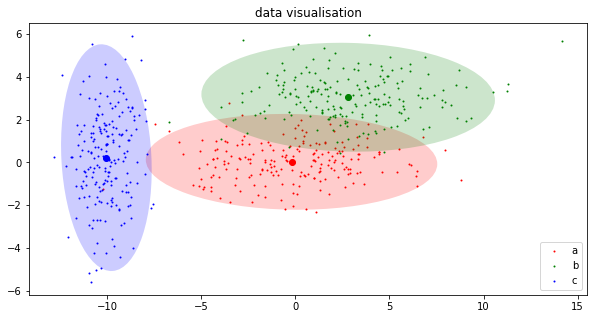

In [4]:
# prepare the data, labels, etc.. 
data   = [a,b,c]
labels = ['a', 'b', 'c']
cmap   = matplotlib.colors.ListedColormap(['r', 'g', 'b']) # colormap for coherent plotting
stats  = [get_stats(d) for d in data] # get statistics on the distribution of the data
priors = [d.shape[0] for d in data]   # get information on the prior distribution of the classes 
priors = priors / np.sum(priors)      # (it should be equal, since there are 200 points in each, but for cleanliness, we do it anyway)


#visualize it for fun
visualize_data(data, labels, stats, cmap=cmap)
plt.show()

number of misclassified points by class : [11, 11, 0]


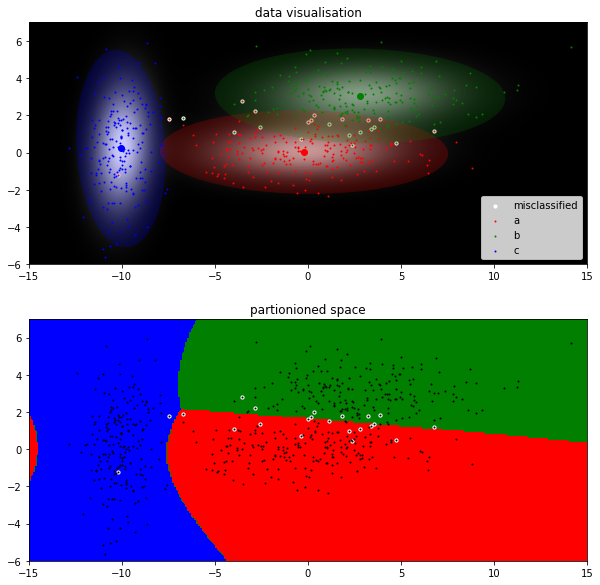

In [5]:
extent = [-15, 15, -6, 7]

# do the thing 
partition, probs = partition_space_Bayes(priors, stats, extent) # get the Bayes partitioning
P = probs[0] + probs[1] + probs[2] # make a single probability distribution containing all points

# get the number of misclassified points 
misclassifieds = [get_misclassified(d, label, partition, extent) for d, label in zip(data, [0,1,2])] 
print("number of misclassified points by class : " + str([len(m) for m in misclassifieds]))




# plot the results 
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].imshow(P.T, origin='lower', extent=extent, cmap='gray')
draw_misclassified(data,  labels=[0,1,2], grid=partition, extent=extent, ax=axes[0])
visualize_data(data, labels, stats, axes[0], cmap=cmap)

axes[1].imshow(partition.T, origin='lower', extent=extent, cmap=cmap, vmin=0, vmax=len(data)-1)
draw_misclassified(data, labels=[0,1,2], grid=partition, extent=extent, ax=axes[1])
for d in data: axes[1].scatter(d[:,0], d[:,1], s=1, color='k')
axes[1].set_title("partionioned space")

plt.show()

### 1.2 Mahalanobis distance (5 pts)
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

In [6]:
# Add your implementation and discussion

def get_Mahalanobis_dist(p, stats=[], data=[]) : # expects a column-vector containing points 
    if stats == [] : stats = get_stats(data)
    dd = p-stats[0]  
    return (dd @ np.linalg.inv(stats[1]) @ dd.T).diagonal() # get the Mahalonobis distance 
    
def partition_space_Mahalanobis(priors, stats, extent) :
    X,Y  = np.mgrid[extent[0]:extent[1]:0.1, extent[2]:extent[3]:0.1]
    grid = np.dstack((X, Y))
    
    # get the M. distance at each gridpoint for each class USING A DOUBLE NESTED FOR LOOP
    grid_dists = [np.array([get_Mahalanobis_dist(p, stat) for p in grid]) for prior, stat in zip(priors, stats)]
    
    partition = np.argmin(grid_dists, axis=0) # the class with the minimum M. distance at each gridpoint wins
    
    return partition, grid_dists

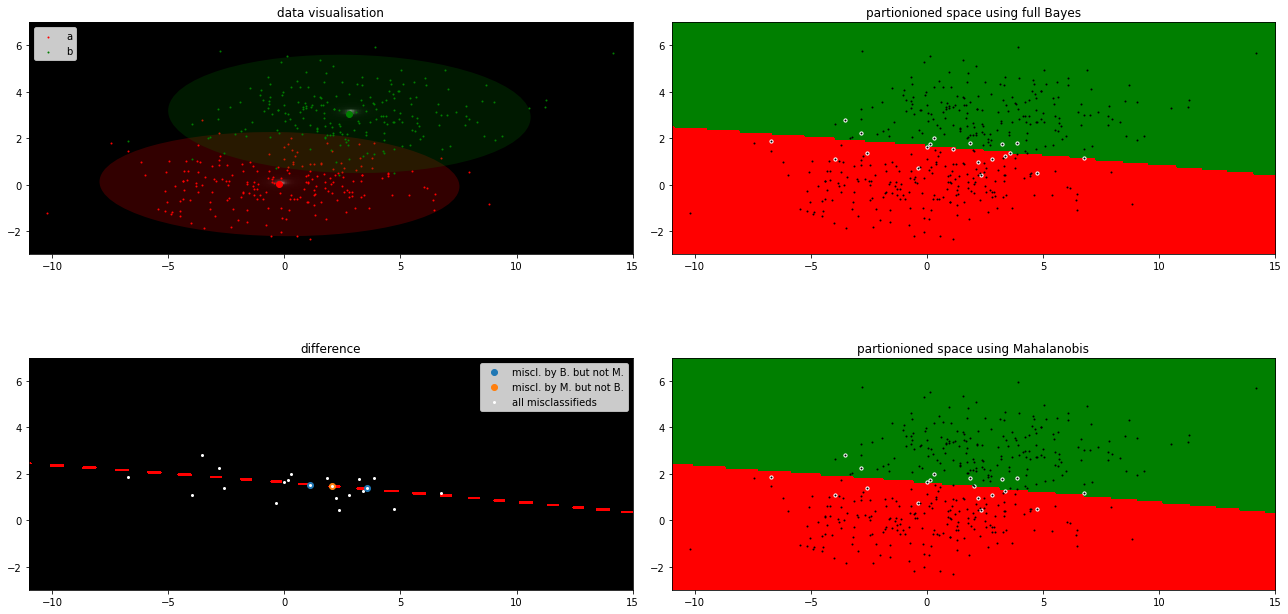

In [7]:
extent = [-11, 15, -3, 7]

# do the thing 
partition_b, gprob = partition_space_Bayes(priors[0:2], stats[0:2], extent)   # get the Bayes partitioning
prob_b = gprob[0] + gprob[1]
partition_m, gd = partition_space_Mahalanobis(priors[0:2], stats[0:2], extent)# get the Mahalanobis partitioning
dm_inv = 1/gd[0] + 1/gd[1]

# compare the two 
miscl_b = np.vstack([get_misclassified(d, label, partition_b, extent) for d, label in zip(data[0:2], [0,1])])
miscl_m = np.vstack([get_misclassified(d, label, partition_m, extent) for d, label in zip(data[0:2], [0,1])])
u_miscl = np.unique(np.vstack([miscl_b, miscl_m]), axis=0)
u_miscl_b, u_miscl_m = get_unique_points(miscl_b, miscl_m)




# visualize 
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# the data
axes[0,0].imshow(dm_inv.T, origin='lower', extent=extent, cmap='gray')
visualize_data(data[0:2], labels[0:2], stats[0:2], axes[0,0], cmap=cmap)

# the Bayes partitioning 
axes[0,1].imshow(partition_b.T, origin='lower', extent=extent, cmap=cmap, vmin=0, vmax=len(data)-1)
draw_misclassified(data[0:2], [0,1], partition_b, extent, ax=axes[0,1])
for d in data[0:2]: axes[0,1].scatter(d[:,0], d[:,1], s=1, color='k')
axes[0,1].set_title("partionioned space using full Bayes")

# the M. partitioning 
axes[1,1].imshow(partition_m.T, origin='lower', extent=extent, cmap=cmap, vmin=0, vmax=len(data)-1)
draw_misclassified(data[0:2], [0,1], partition_m, extent, ax=axes[1,1])
for d in data[0:2]: axes[1,1].scatter(d[:,0], d[:,1], s=1, color='k')
axes[1,1].set_title("partionioned space using Mahalanobis")

# plot the differences
axes[1,0].imshow((partition_b-partition_m).T,  origin='lower', extent=extent, cmap=matplotlib.colors.ListedColormap([ 'r', 'k', 'g']), vmin=-1, vmax=1)
axes[1,0].scatter(u_miscl_b[:,0], u_miscl_b[:,1], label="miscl. by B. but not M.")
axes[1,0].scatter(u_miscl_m[:,0], u_miscl_m[:,1], label="miscl. by M. but not B.")
axes[1,0].scatter(u_miscl[:,0], u_miscl[:,1], s=4, color="white", label="all misclassifieds")
axes[1,0].set_title("difference")
axes[1,0].legend()


plt.tight_layout()
plt.show()


---

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python. 

**! Warning**: When the lab was created the official MNIST repo was down, if it is still the case please use https://github.com/mkolod/MNIST.

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [8]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [9]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

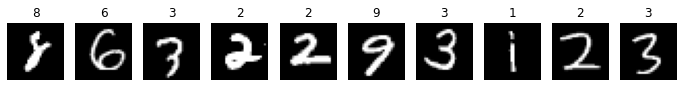

In [10]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

### 2.2 MLP (10 pts)

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [11]:
# Add your implementation and discussion

# reshape in order to have a (-,784) size train and test dataset in the input layer
train_images = train_images.reshape(train_set_size,-1) #(60000, 784)
test_images = test_images.reshape(test_set_size,-1) #(10000, 784)

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

hidden_units = 100
# MLP classifier
clf = MLPClassifier(solver='adam', alpha=1e-4, learning_rate="invscaling", learning_rate_init=1e-4,
                    hidden_layer_sizes=(hidden_units), random_state=1, max_iter=200, verbose=False)

# model fitting
clf.fit(train_images, train_labels)

MLPClassifier(hidden_layer_sizes=100, learning_rate='invscaling',
              learning_rate_init=0.0001, random_state=1)

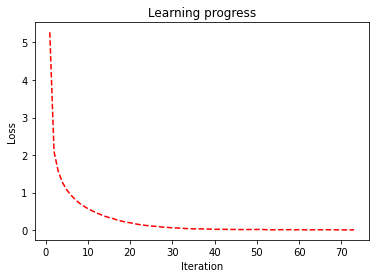

In [13]:
# learning visualization 
plt.plot(np.linspace(1,len(clf.loss_curve_),num=len(clf.loss_curve_)), clf.loss_curve_, 'r--')
plt.title("Learning progress")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.show()

In [14]:
# prediction with our MLP model
labels_predict = clf.predict(test_images)

# accuracy score 
accuracy = metrics.accuracy_score(labels_predict,test_labels) 
print("Accuracy (Correctly labeled) :",accuracy)

Accuracy (Correctly labeled) : 0.9563


Using a gradually decreasing learning rate (invscaling) with the adam solver, the accuracy improves continously at each
iteration until the training converges after 79 iterations. The computed model has an accuracy of 95,63% on the testing set.